---

## 12.4 Generating images with variational autoencoders

Reminder, to connect to your drive:

```python
import sys

# reminder: Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('drive/My Drive/IS53024B-Artificial-Intelligence/8-generative-deep-learning') # 'My Drive' is the default name of Google Drives,
    os.listdir()
```    

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import YouTubeVideo

import tensorflow as tf

---

### 12.4.1 Sampling from latent spaces of images

Many times we have seen that **information bottlenecks** can be a problem for us.

This time, we want to turn those to our advantage!

Imagine if we could compress images to a **lower-dimensional space**, a **latent space**, with good properties.

In such a space, each point (coordinate) would corresponds to a realistic image!

<img style="height:600px" src="images/chollet.latent-space-sampling.p.392.png">
<!-- <img style="height:600px" src="https://drive.google.com/uc?id=1zV804ID4DXa-jT93ON-pyTjWMB9Zh5Z7"> -->

<small>DLWP, p.392</small>


A *generator* or *decoder* module (in a GAN or a VAE, respectively) transforms a point in the latent space back to the source distribution, in our case: images.

Any point in the latent space can be sampled.

The sampling and reconstruction process means that new, never seen before, yet (hopefully) realistic, images can be created.

<img src="images/chollet.latent-space-continuous.p.392.png">
<!-- <img style="height:400px" src="https://drive.google.com/uc?id=1HvS8Oe2dmTcdFPGztrSdpyespvnoN4mE"> -->

<small>DLWP, p.392</small>


GANs and VAEs generate latent spaces in different ways.

VAEs are good at generating **structured latent spaces** where specific directions encode meaningful data.

GANs generate **very realistic images** but the latent space may **not be so structured** and is less useful for image editing.

---

### 12.4.2 Concept vectors for image editing

Similar to embeddings: inside the embedded space, you can do vector math with meanings!

```python
Tokyo - Japan + China = Beijing
```

<img style="height:400px" src="images/nlp/linear-relationships.svg">
<!-- <img style="height:400px" src="https://drive.google.com/uc?id=1qsmSHdJxMYmnapU0br6ESLc69deKedcj"> -->

<small>[Embeddings: Translating to a Lower-Dimensional Space, Google Foundational Courses, Machine Learning, Embeddings](https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space)</small>


Different vectors / dimensions encode interesting properties, e.g. a **'smile' vector**.

If you have found a smile vector, you can project an image into the latent space, add a smile vector, and then decode.

The resulting image will have more 'smile' inside it.

Concept vectors naturally emerge for many properties  e.g. sunglasses, beards, etc...

![Chollet, concept vector](images/chollet.concept-vector.p.393.png)
<!-- <img src="https://drive.google.com/uc?id=1_unlbl6CEPiUxeW18Vbifh_sdpVuG5g4"> -->

<small>DLWP, p.393</small>

---

### 12.4.3 Variational autoencoders

A **classic autoencoder** maps an image to a low dimensional fixed code (a vector) and then decodes back to the original space.

The autoencoder learns a kind of compression, and 
The autoecoder then learns by comparing its decoded output with the input. It is **self-supervised**!

But these classic spaces are not structured in a useful way, *and* it's **deterministic**!

![Autoencoder](https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg)

<small>DLWP, p.394</small>

**Variational autoencoders** do not compress data into a fixed code in the latent space, but learn the **parameters of a probability distribution** (its mean and variance).

The assumption is that the output image is the result of a statistical process.  
(The randomness of this process should be taken into account during encoding and decoding.)

The randomness (stochasticity) as well as the specific loss used improve robustness and forces the latent space to encode meaningful representations everywhere.

![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)

<small>DLWP, p.395</small>

##### Workflow

1. The encoder module maps an input image to a *mean* $\mu$ and a *variance* $\sigma$;
2. We randomly sample: $z \sim N(\mu, \sigma^2)$ i.e. $z \sim \mu + \sigma N(0, 1)$;
3. The decoder module maps $z$ back to the original image space.

### The loss functions

1. The **reconstruction loss**: forces the decoded samples to match the initial inputs;
2. The **regularisation loss**: ensures well-formed latent spaces and minimal overfitting.

The stochastic sampling means that slightly different latent vectors will be generated from the same source.

The decoder is attempting to decode all the random latent vectors emanating from the same source to the same target (which is identical to the source!).

=> neighbouring points in the latent space are decoded to the same image.



### Sampling from a normal distribution

$$
\bbox[5px,border:2px solid red]{
z \sim N(\mu, \sigma^2)
}
$$

$z$: sample  
$\mu$: mean  
$\sigma^2$: variance  
$N$: normal distribution  

You can think of $\mu$ as a point in the latent space and $\sigma$ defining an area around this point.

The **regularisation loss** ensures that the $z$'s are clustered together at the centre of the latent space.



The $\sigma$ areas overlap so that a continuous and structured representation is built.

That representation is densely packed, so that any sampled point from it should yield a new valid data point.

New images are generated by decoding a selected point $z$ in the latent space.

In [ ]:
YouTubeVideo("sV2FOdGqlX0", width=853, height=480)

---

### 12.4.4 Implementing a VAE with Keras

**VAE encoder network**

In [3]:
latent_dim = 2
def build_encoder(latent_dim=2):
    encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(16, activation="relu")(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)               # MEAN
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)         # LOG OF VARIANCE = log(sigma**2)
    return tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder") # (log for math/stability)
encoder = build_encoder(latent_dim=latent_dim)

In [4]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

**Latent-space-sampling layer**

In [5]:
class Sampler(tf.keras.layers.Layer):
    """From a mean mu and a log variance, sample a number with mu + sigma * epsilon"""
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size)) # epsilon, a vector of random numbers
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon      # this is equivalent to mu + sigma * epsilon

In [28]:
# Why the above formula works?

std = 1.4
var = std**2
log_var = np.log(var)
print(f"std: {std}")
print(f"var: {var}")
print(f"log var: {log_var}")
print(f"and back to std: {tf.exp(0.5 * log_var).numpy()}")
print()
print("The log and the exp functions are reciprocal,")
print("and 0.5 * log(var) == log(var ** 0.5) == log(sqrt(var)).")
print()
print("0.5 * log_var == np.log(np.sqrt(var))?", np.allclose(0.5 * log_var, np.log(np.sqrt(var)))) 

std: 1.4
var: 1.9599999999999997
log var: 0.6729444732424257
and back to std: 1.4

The log and the exp functions are reciprocal,
and 0.5 * log(var) == log(var ** 0.5) == log(sqrt(var)).

0.5 * log_var == np.log(np.sqrt(var))? True


**VAE decoder network, mapping latent space points to images**

[`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) docs. See also [this article](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d), and especially [that paper](https://arxiv.org/abs/1603.07285) ([github](https://github.com/vdumoulin/conv_arithmetic)).

![Kaveh, stack overflow](images/deconv/deconv.1.png)
<!-- ![Kaveh, stack overflow](https://drive.google.com/uc?id=1SnOH8oSc-Nm8BnfgBscZ9ZoreU4JFpxN) -->

<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

![Kaveh, stack overflow](images/deconv/deconv.2.png)
<!-- ![Kaveh, stack overflow](https://drive.google.com/uc?id=1WFs76_P33NQgvugVWPPyft_4zfWMhJ_9) -->


<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

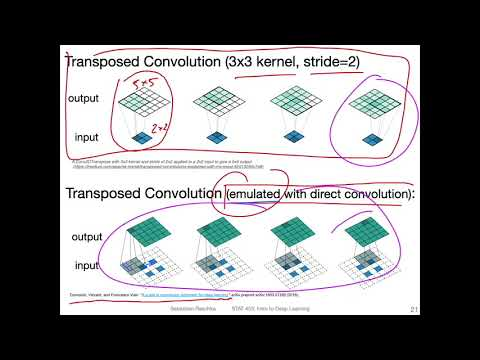

In [4]:
YouTubeVideo('ilkSwsggSNM', width=853, height=480) # Sebastian Rashka, transposed convolutions

In [6]:
def build_decoder(latent_dim=2):
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # CONV 2D TRANSPOSE
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = tf.keras.layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
    return tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder = build_decoder(latent_dim=latent_dim)

In [7]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

**VAE model with a custom `train_step()`**

For the derivation of the KL divergence loss, see [the paper](https://arxiv.org/pdf/1312.6114.pdf), p. 5, and Appendix B, pp. 10-11.

In [8]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:                                    # 1. GENERATION
            z_mean, z_log_var = self.encoder(data)                         #   a. encode to mean & log var
            z = self.sampler(z_mean, z_log_var)                            #   b. a batch of random numbers
            reconstruction = decoder(z)                                    #   c. decode into reconstructed images

            reconstruction_loss = tf.reduce_mean(                          # 2. LOSSES
                tf.reduce_sum(                                             #   a. reconstruction_loss: BCE 
                    tf.keras.losses.binary_crossentropy(data, reconstruction), #  between data & reconstructions
                    axis=(1, 2)
                )
            )                                                              #   b. regularisation loss
                                                                           #      Kullback-Leibler divergence
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # (→ the latent distribution 
                                                                                     # is close to a Gaussian)
            
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)     #   c. total

        grads = tape.gradient(total_loss, self.trainable_weights)          # 3. BACKPROP
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) #   a. compute & apply gradients

        self.total_loss_tracker.update_state(total_loss)                   #   b.update our metrics trackers
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


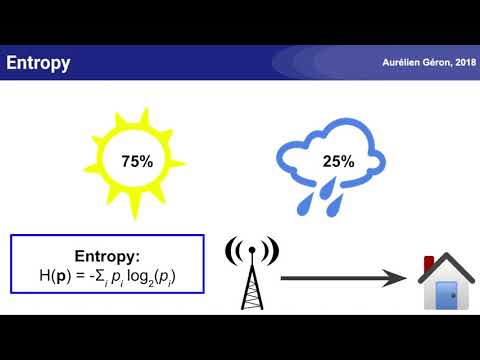

In [6]:
YouTubeVideo('ErfnhcEV1O8', width=853, height=480) # A Short Introduction to Entropy, Cross-Entropy and KL-Divergence 

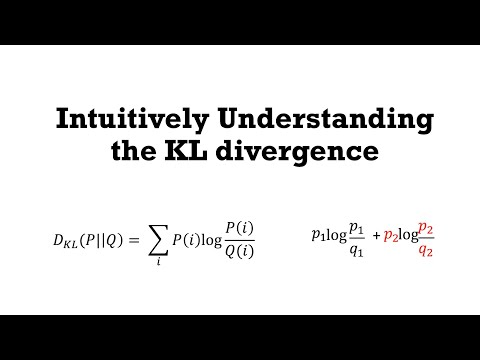

In [2]:
YouTubeVideo('SxGYPqCgJWM', width=853, height=480) #  Intuitively Understanding the KL Divergence 

**Training the VAE**

In [9]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [47]:
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=tf.keras.optimizers.Adam(),
    run_eagerly=True,
)

batch_size = 128
vae.fit(
    mnist_digits,
    epochs=30,
    batch_size=batch_size,
)

Epoch 1/30
547/547 [==============================] - 43s 78ms/step - total_loss: 148.1924 - reconstruction_loss: 144.7248 - kl_loss: 3.4677
Epoch 2/30
547/547 [==============================] - 48s 88ms/step - total_loss: 147.5052 - reconstruction_loss: 144.0196 - kl_loss: 3.4856
Epoch 3/30
547/547 [==============================] - 45s 83ms/step - total_loss: 147.1440 - reconstruction_loss: 143.6355 - kl_loss: 3.5084
Epoch 4/30
547/547 [==============================] - 45s 82ms/step - total_loss: 146.8417 - reconstruction_loss: 143.3138 - kl_loss: 3.5279
Epoch 5/30
547/547 [==============================] - 45s 81ms/step - total_loss: 146.6022 - reconstruction_loss: 143.0663 - kl_loss: 3.5359
Epoch 6/30
547/547 [==============================] - 43s 78ms/step - total_loss: 146.3994 - reconstruction_loss: 142.8587 - kl_loss: 3.5408
Epoch 7/30
547/547 [==============================] - 40s 74ms/step - total_loss: 146.1995 - reconstruction_loss: 142.6577 - kl_loss: 3.5419
Epoch 8/30
54

**Sampling a grid of images from the 2D latent space**

In [10]:
from IPython.display import clear_output

def plot_latent_space(vae):
    n = 30
    img_size = 28
    figure = np.zeros((img_size * n, img_size * n))              # empty pixels

    grid_x = np.linspace(-1, 1, n)                               # linearly spaced values for x
    grid_y = np.linspace(-1, 1, n)[::-1]                         # linearly spaced values for y

    tot = len(grid_y) * len(grid_x)
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            clear_output(wait=True)
            print(f"{i*len(grid_y) + j + 1}/{tot}")
            z_sample = np.array([[xi, yi]])                      # 1. sample at (xi, yi) coordinate
            x_decoded = vae.decoder.predict(z_sample, verbose=0) # 2. decode image from sample
            img = x_decoded[0].reshape(img_size, img_size)       # 3. include image into our grid
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = img

    plt.figure(figsize=(15, 15))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.axis("off")
    plt.imshow(figure, cmap="Greys_r")

900/900

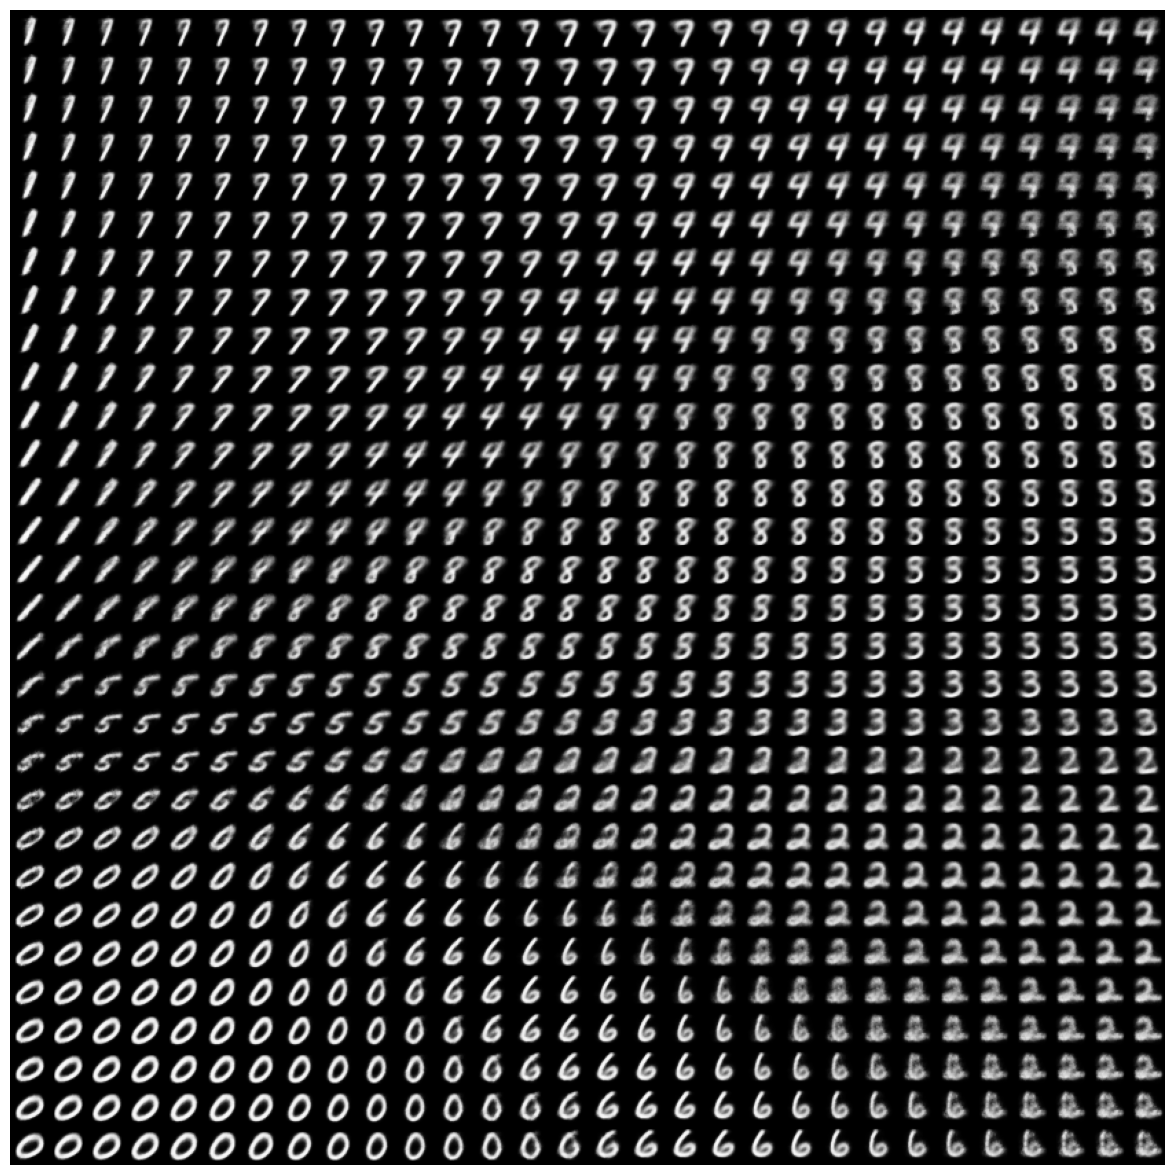

In [49]:
plot_latent_space(vae)

---

### References

[Kingma and Welling, "Auto-Encoding Variational Bayes"](https://arxiv.org/abs/1312.6114)  
[Kingma and Welling, "An Introduction to Variational Autoencoders"](https://arxiv.org/abs/1906.02691)

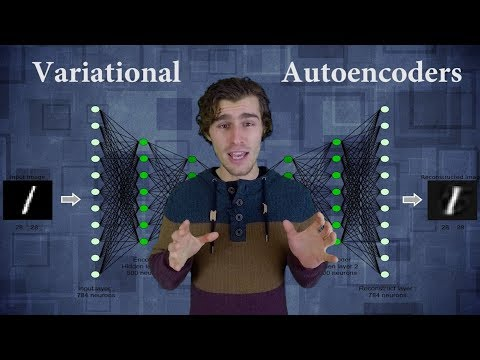

In [3]:
YouTubeVideo('9zKuYvjFFS8', width=853, height=480) # Arxiv insight, Variational Autoencoders

---

### 12.4.5 Wrapping up

- **Encoding**: we learn a **latent spaces** capturing statistical information about a dataset of images;
- **Decoding**: new images are produced by sampling and decoding points from the latent space;
- The latent space **compresses** the data in a way that is not dissimilar to **word embeddings**;

Two major approaches to do this: **Variational Autoencoders** (VAEs) and **Generative Adversarial Networks** (GANs).

### VAEs

- **VAEs** result in **highly structured, continuous latent representations**;
- They work well for **image editing in latent space**: face swapping, turning a frowning face into a smiling face, and so on;
- VAEs also work nicely for **latent-space-based animations** e.g. a walk along a cross section of the latent space, showing a starting image slowly morphing into different images in a continuous way.


### GANs

- GANs generate **(very) realistic single-frame images** but
- only **implicitly** create latent spaces, and 
- not necessarily spaces with solid structure and high continuity.

### Further experiments

Try the **Celeb Faces Attributes** (CelebA) dataset instead of MNIST. See the GAN notebook!

It’s a free-to-download image dataset containing more than 200,000 celebrity portraits.

Available in the external [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/celeb_a) module, [Kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) and the [original project page](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

Can you isolate and work with the **smile vector**??